In [1]:
!pwd

/Users/yuanshi/Library/CloudStorage/Box-Box/Sequence Analysis/2025/D1D2_organize/script_DNA


In [2]:
# QC

In [3]:
import pandas as pd
import hashlib
import json,os
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#check md5 and store
def get_file_md5(file_path):
    md5_hash = hashlib.md5()
    with open(file_path, "rb") as file:
        for chunk in iter(lambda: file.read(4096), b""):
            md5_hash.update(chunk)
    return md5_hash.hexdigest()

def store_md5_in_json(file_paths, json_output):
    md5_dict = {}
    for file_path in file_paths:
        md5_hash = get_file_md5(file_path)
        md5_dict[file_path] = md5_hash

    with open(json_output, "w") as json_file:
        json.dump(md5_dict, json_file, indent=4)

In [5]:
#load from previous session
with open('../picklefiles/notebook1.pkl','rb') as f:
    info = pickle.load(f)

print (info.keys())

dict_keys(['reffile'])


In [6]:
reffile = info['reffile']

In [7]:
reffile

SeqID     Index Mouse_Cohort MouseID Organ Treatment
0    NovaSeq022125  Sample14      JCMMG32     #44   LIV   D1D2-NK
1    NovaSeq022125   Sample3      JCMMG32     #44    SP   D1D2-NK
2    NovaSeq022125   Sample6      JCMMG32     #44    BM   D1D2-NK
3    NovaSeq022625   UDP0003      JCMMG32     #44    SP   D1D2-NK
4    NovaSeq022625   UDP0006      JCMMG32     #44    BM   D1D2-NK
..             ...       ...          ...     ...   ...       ...
262  NovaSeq061325   UDP0043      JCMMG32     #26    BM    GFP-NK
263  NovaSeq061325   UDP0049       JMGA36     #30    BM     No NK
264  NovaSeq061325   UDP0053       JMGA36     #38    BM    GFP-NK
265  NovaSeq061325   UDP0098       JMGA36     #37   LIV     No NK
266  NovaSeq061325   UDP0100      JCMMG33      #6    BM   D1D2-NK

[267 rows x 6 columns]

# Generate all data

In [8]:
adata = dict()
for _,entry in reffile.iterrows():
    seqID = entry['SeqID']
    index = entry['Index']
    name = '{}_{}'.format(seqID,index)
    filepath = os.path.join('../linkage_files/','{}.txt'.format(name))
    tdata = pd.read_csv(filepath,sep='\t',names=['UMI','read count','barcode','barcode_confidence','2nd_barcode_freq','provirus type','site','site_confidence','2nd_site_freq','mapping length'] )
    adata[name] = tdata

In [9]:
with open('../picklefiles/adata.pickle','wb') as f:
    pickle.dump(adata,f)

In [10]:
reffile['SeqLibraryID'] = reffile.apply(lambda x: '{}_{}'.format(x['SeqID'],x['Index']),axis=1)

In [11]:
def get_confidence (ID,cutoff):
    tdata = adata[ID]
    if max(tdata['read count'])>5:
        fdata = tdata[tdata['read count']>5]
    else:
        fdata = tdata
    return len(fdata[fdata['barcode_confidence']>cutoff])/len(fdata)

reffile['Depth'] = reffile['SeqLibraryID'].apply(lambda x: np.sum(adata[x]['read count']))
reffile['Confidence'] = reffile['SeqLibraryID'].apply(lambda x: get_confidence(x,0.8))

reffile['UMIover5'] = reffile['SeqLibraryID'].apply(lambda x: len(adata[x][adata[x]['read count']>5]))
reffile['SampleID'] = reffile.apply(lambda x: '{}-{}-{}'.format(x['Mouse_Cohort'],x['MouseID'],x['Organ']),axis=1)

In [12]:
!mkdir ../figures

mkdir: ../figures: File exists


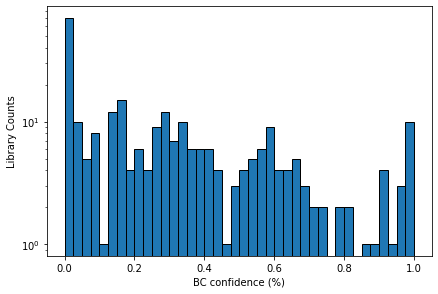

In [13]:
plt.hist(reffile['Confidence'],log=True,bins=40,edgecolor='black')
plt.tight_layout()
plt.xlabel('BC confidence (%)')
plt.ylabel('Library Counts')
plt.savefig('../figures/overall_bcconfidence.png',dpi=300)

In [14]:
#picking the library to analyze
pick = {SeqLibID:0 for SeqLibID in reffile['SeqLibraryID'].values}

SampleIDs = reffile['SampleID'].unique()

In [15]:
len(pick)

267

In [16]:
arr = []
for SampleID in SampleIDs:
    libraries = reffile[reffile['SampleID'] == SampleID]
    if len(libraries) == 1:
        pick[libraries.iloc[0]['SeqLibraryID']] = 1 #has to pick, only one library exists
        continue
    arr.append(SampleID)

In [17]:
print ("total libraries:", len(pick))
print ("sent once:",len([i for i in pick if pick[i]==1]))
print ("sent multiple times:",len(arr))

total libraries: 267
sent once: 26
sent multiple times: 91


# Check Quality

/opt/anaconda3/envs/new/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'confident BC fraction')

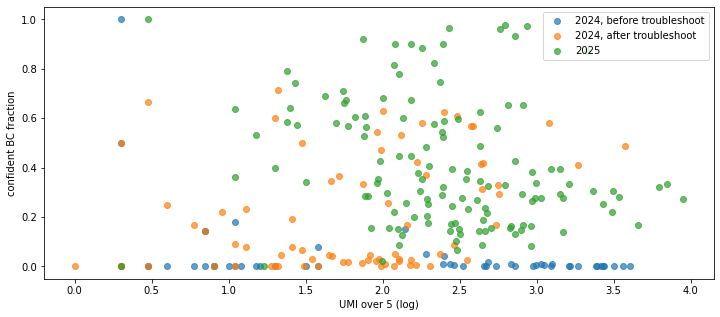

In [18]:
plt.figure(figsize=[12,5])
seq1 = reffile[reffile['SeqID'].apply(lambda x: x in ('NovaSeq043024','NovaSeq052924'))]
seq2 = reffile[reffile['SeqID'].apply(lambda x: x.endswith('24') and x not in ('NovaSeq043024','NovaSeq052924'))]
seq3 = reffile[reffile['SeqID'].apply(lambda x: x.endswith('25'))]

plt.scatter(np.log10(seq1['UMIover5']),seq1['Confidence'],label = '2024, before troubleshoot',alpha=0.7)
plt.scatter(np.log10(seq2['UMIover5']),seq2['Confidence'],label = '2024, after troubleshoot',alpha=0.7)
plt.scatter(np.log10(seq3['UMIover5']),seq3['Confidence'],label = '2025',alpha=0.7)

plt.legend()

plt.xlabel('UMI over 5 (log)')
plt.ylabel('confident BC fraction')

In [19]:
reffile['sort'] = reffile['SeqID'].apply(lambda x: (int(x[-2:])*100+int(x[7:9])))

In [20]:
coordinates = []
for name in arr:
    tdata = reffile[reffile['SampleID']==name].sort_values('sort')
    for i in range(len(tdata)-1):
        start_corr = (np.log10(tdata['UMIover5'].iloc[i]),tdata['Confidence'].iloc[i])
        end_corr = (np.log10(tdata['UMIover5'].iloc[i+1]),tdata['Confidence'].iloc[i+1])
    coordinates.append((start_corr,end_corr))

/var/folders/cn/m45cgcz92v7f43x41pfxqsc9kphhnj/T/ipykernel_34787/673125925.py:5: RuntimeWarning: divide by zero encountered in log10
  start_corr = (np.log10(tdata['UMIover5'].iloc[i]),tdata['Confidence'].iloc[i])
/var/folders/cn/m45cgcz92v7f43x41pfxqsc9kphhnj/T/ipykernel_34787/673125925.py:6: RuntimeWarning: divide by zero encountered in log10
  end_corr = (np.log10(tdata['UMIover5'].iloc[i+1]),tdata['Confidence'].iloc[i+1])


In [21]:
len(coordinates)

91

/opt/anaconda3/envs/new/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/new/lib/python3.11/site-packages/matplotlib/patches.py:1471: RuntimeWarning: invalid value encountered in scalar divide
  cx = self._dx / distance
/opt/anaconda3/envs/new/lib/python3.11/site-packages/matplotlib/patches.py:1478: RuntimeWarning: invalid value encountered in scalar add
  self._x + self._dx,


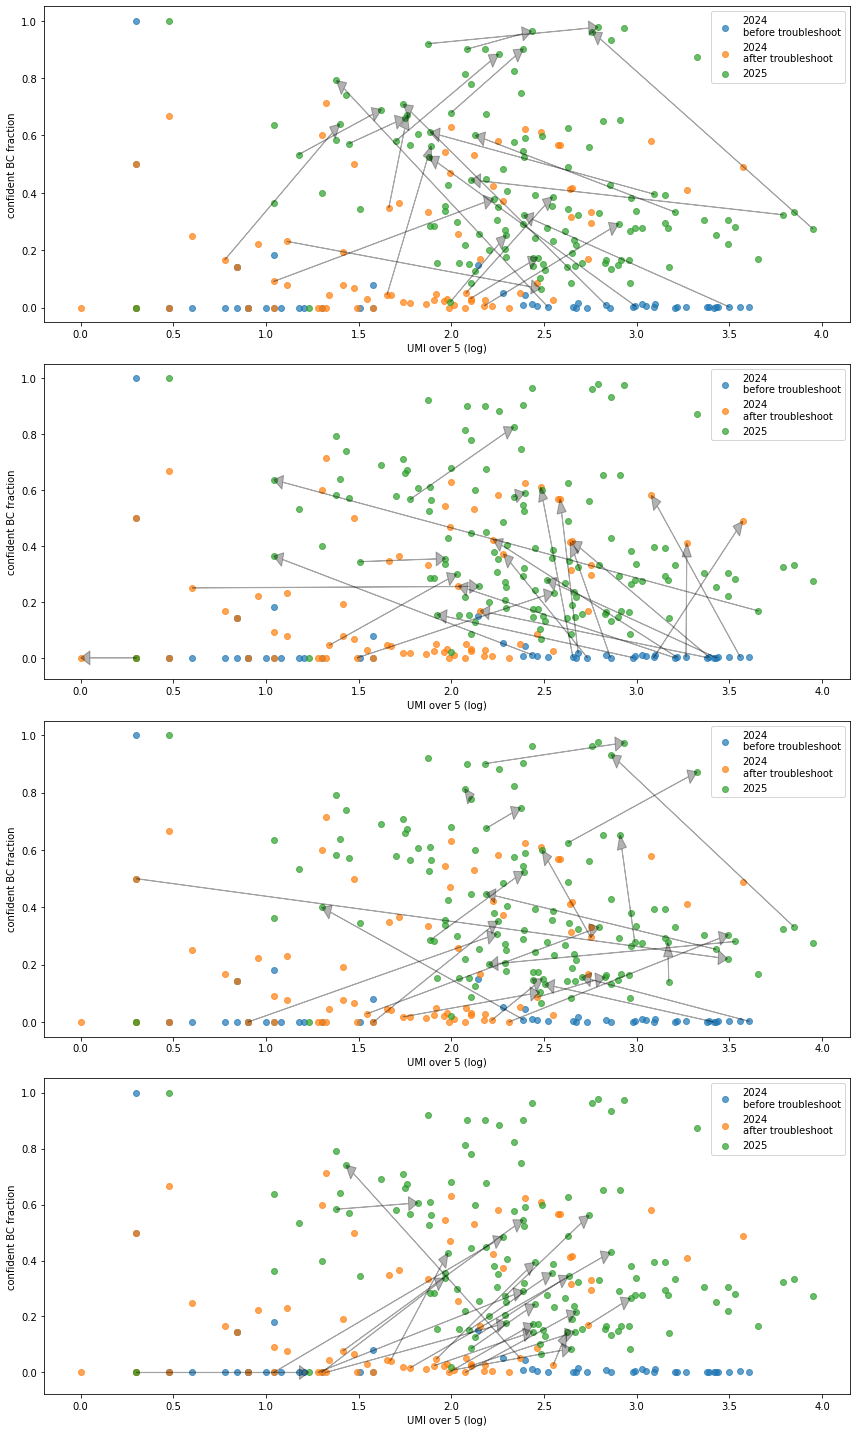

In [22]:
seq1 = reffile[reffile['SeqID'].apply(lambda x: x in ('NovaSeq043024','NovaSeq052924'))]
seq2 = reffile[reffile['SeqID'].apply(lambda x: x.endswith('24') and x not in ('NovaSeq043024','NovaSeq052924'))]
seq3 = reffile[reffile['SeqID'].apply(lambda x: x.endswith('25'))]

fig,axes = plt.subplots(4,1,figsize=[12,20])

for idx,ax in enumerate(axes):
    ax.scatter(np.log10(seq1['UMIover5']),seq1['Confidence'],label = '2024\nbefore troubleshoot',alpha=0.7)
    ax.scatter(np.log10(seq2['UMIover5']),seq2['Confidence'],label = '2024\nafter troubleshoot',alpha=0.7)
    ax.scatter(np.log10(seq3['UMIover5']),seq3['Confidence'],label = '2025',alpha=0.7)
    ax.legend()
    ax.set_xlabel('UMI over 5 (log)')
    ax.set_ylabel('confident BC fraction')

    size = len(coordinates)//4+1
    end = min(idx*size+size,len(coordinates))
    for i in range(idx*size,end):
        s=coordinates[i]
        x1,y1 = s[0]
        x2,y2 = s[1]
        ax.arrow(x1, y1, x2-x1, y2-y1,head_width=0.05, head_length=0.05,fc='black',length_includes_head=True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/QC_improvement.png',dpi=300)

In [23]:
# if exlude the 2024 before troubleshoot sample, does the data look better?

In [24]:
len(reffile[~reffile['SeqID'].isin(('NovaSeq043024','NovaSeq052924'))]['SampleID'].unique())

117

# Pick libraries for analysis

In [25]:
# change the pick to pick those that are not in trouble libraries
reffile['pick'] = ~reffile['SeqID'].isin(('NovaSeq043024','NovaSeq052924'))

In [26]:
d1 = reffile[reffile['pick']].groupby('SampleID').sum()[['Depth']].copy()
d1.columns = ['Depth1']
d2 = reffile[~reffile['pick']].groupby('SampleID').sum()[['Depth']].copy()
d2.columns = ['Depth2']

In [27]:
d = pd.merge(d1,d2,left_index=True,right_index=True,how='outer').replace(np.nan,0)

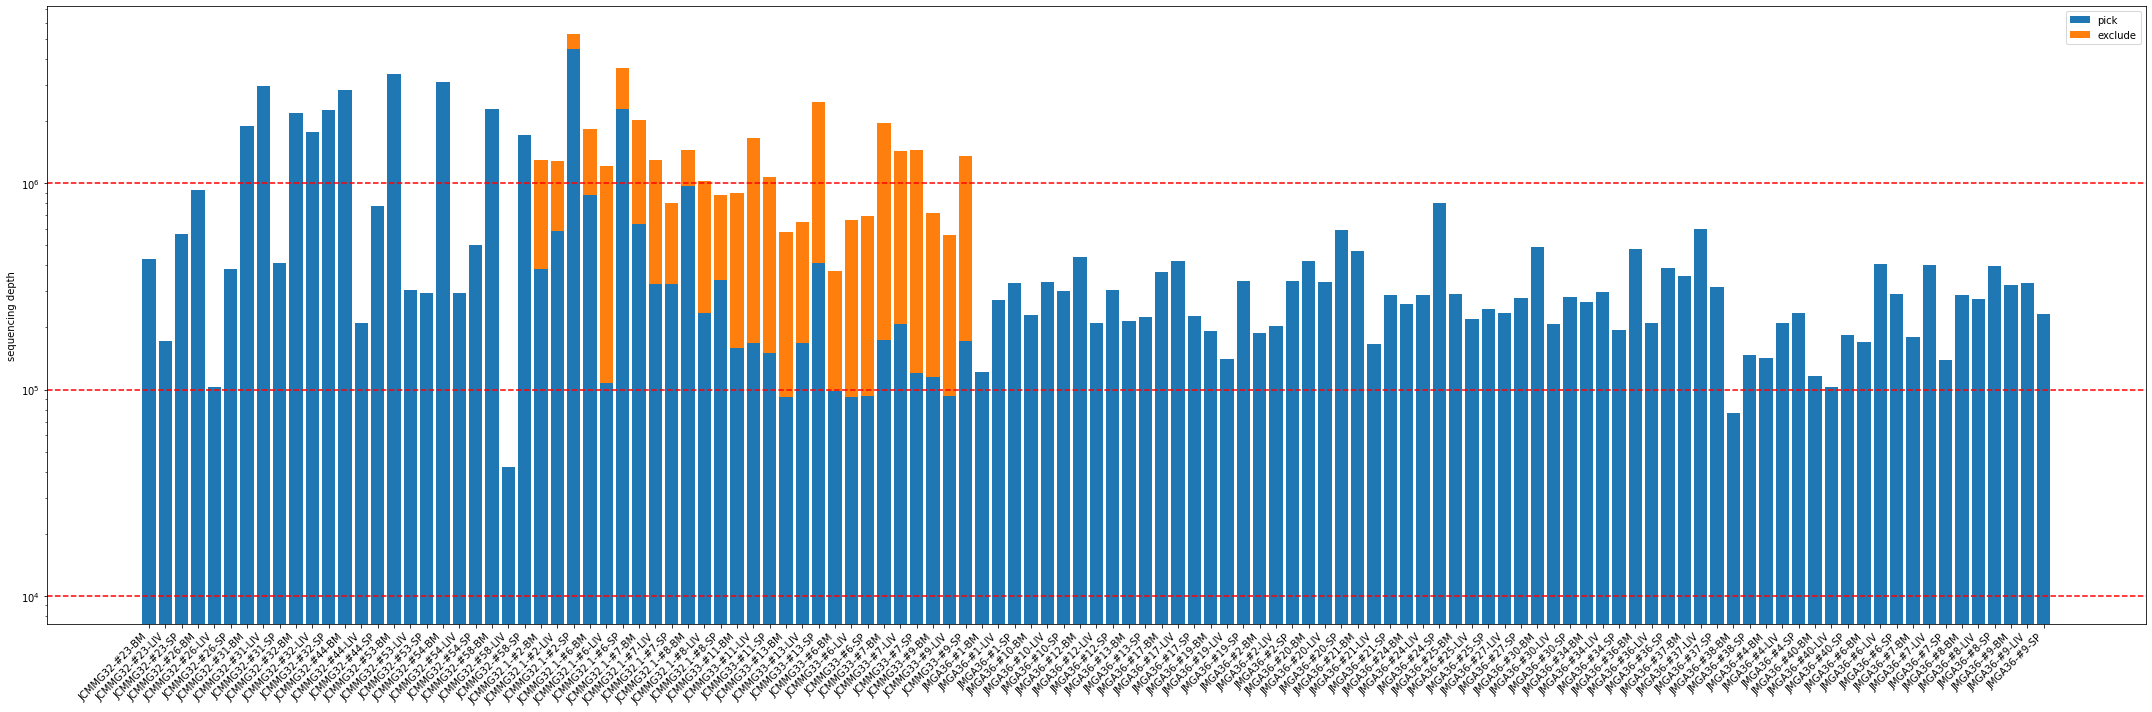

In [28]:
fig,ax = plt.subplots(figsize=[30,10])
positions = np.arange(len(d))
ax.bar(positions,d['Depth1'],label='pick')
ax.bar(positions,d['Depth2'],bottom=d['Depth1'],label='exclude')
x1,x2 = ax.get_xlim()
ax.plot([x1,x2],[10**6,10**6],c='red',ls='--')
ax.plot([x1,x2],[10**5,10**5],c='red',ls='--')
ax.plot([x1,x2],[10**4,10**4],c='red',ls='--')
ax.set_ylabel('sequencing depth')
ax.set_xlim(x1,x2)

ax.set_yscale('log')
ax.set_xticks(positions)
ax.set_xticklabels(d.index,rotation=45,ha='right');
ax.legend()
plt.tight_layout()
plt.savefig('../figures/QC_SequencingDepth.png',dpi=300)

# Concatenate Data for multiple sequencing
1. assign barcode and IS to the top UMI based on read count
2. for barcode confidence, calculate as sigma (confidence*readcount fraction)
3. for IS confidence, calculate as sigma (confidence*readcount fraction)

In [29]:
pdata = dict() #pdata is the one that use SampleID as key, concatenated dataframe as value, pick_data

In [30]:
def fix_UMI(UMI):
    try:
        return str(UMI)
    except:
        return '-'

for SampleID in SampleIDs:
    tdata = reffile[(reffile['SampleID'] == SampleID) & (reffile['pick'])]
    if len(tdata) == 1:
        pdata[SampleID] = adata[tdata.iloc[0]['SeqLibraryID']][['UMI','read count','barcode','barcode_confidence','provirus type','site','site_confidence','mapping length']]
    else:
        try:
            cdata = pd.concat([adata[SID] for SID in tdata['SeqLibraryID']]).sort_values('read count',ascending=False)
            cdata['UMI'] = cdata['UMI'].apply(fix_UMI)
            umi_total_reads = cdata.groupby('UMI')['read count'].sum().to_dict()
            cdata['weighted_bc_confidence'] = cdata.apply(lambda row: (row['barcode_confidence'] * row['read count']) / umi_total_reads[row['UMI']], axis=1)
            cdata['weighted_is_confidence'] = cdata.apply(lambda row: (row['site_confidence'] * row['read count']) / umi_total_reads[row['UMI']], axis=1)
            cdata['total read count'] = cdata['UMI'].map(umi_total_reads)
            read_count = cdata.groupby('UMI').sum()[['read count']]
            cdata = cdata.drop_duplicates('UMI')[['UMI','total read count','barcode','weighted_bc_confidence','provirus type','site','weighted_is_confidence','mapping length']]
            cdata.columns = ['UMI','read count','barcode','barcode_confidence','provirus type','site','site_confidence','mapping length']
            pdata[SampleID] = cdata
        except:
            print(SampleID)

In [31]:
# draw the confidence map

## Decide filter threshold

In [32]:
SampleIDs = sorted(SampleIDs)

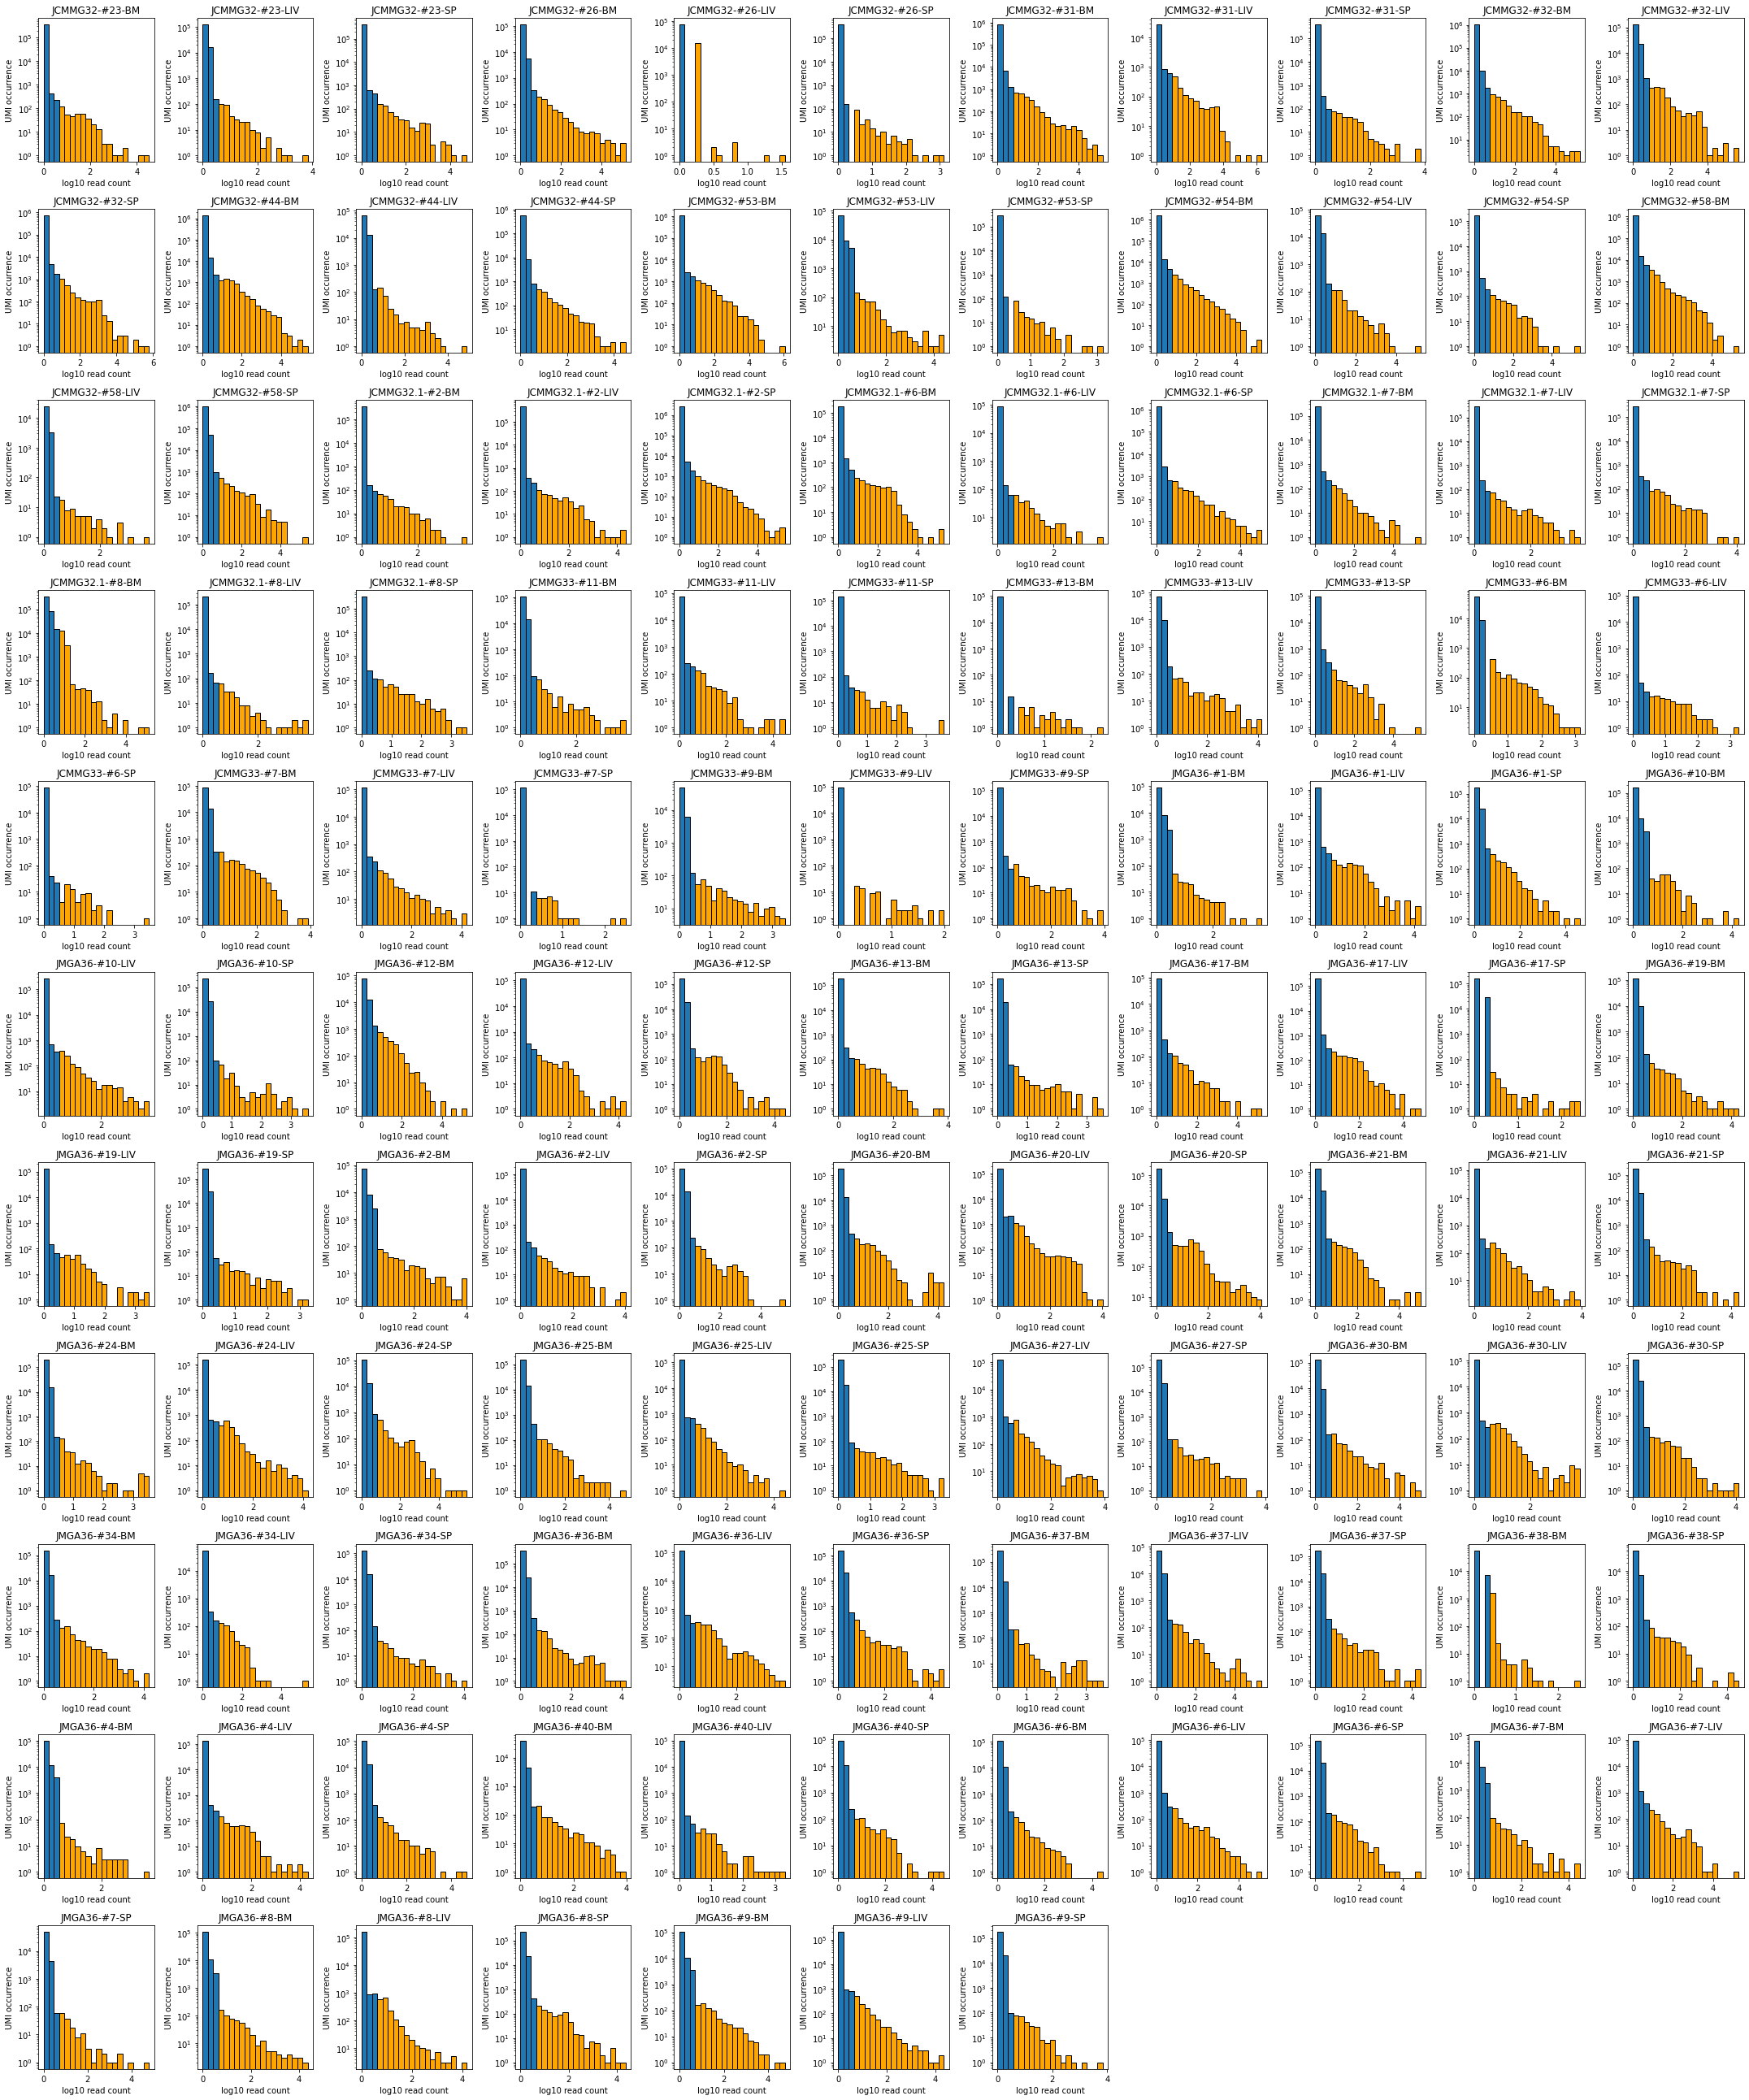

In [33]:
plt.figure(figsize=(30,36))
ploti = 0
thredict = {}
for num in SampleIDs:
    ploti += 1
    plt.subplot(11,11,ploti)
    ns,bins,patches = plt.hist(np.log10(pdata[num]['read count']),edgecolor='black',bins=20)
    for i in range(3,len(ns)):
        patches[i].set_facecolor('orange')
    #thredict[num] = 10**bins[3] # this is the filter setup, set as 5 or as first three bins?
    thredict[num] = 5
    plt.yscale('log')
    plt.xlabel('log10 read count')
    plt.ylabel('UMI occurrence')
    plt.title(num)
plt.tight_layout()
plt.savefig('../figures/UMIdistribution.png',dpi=300)

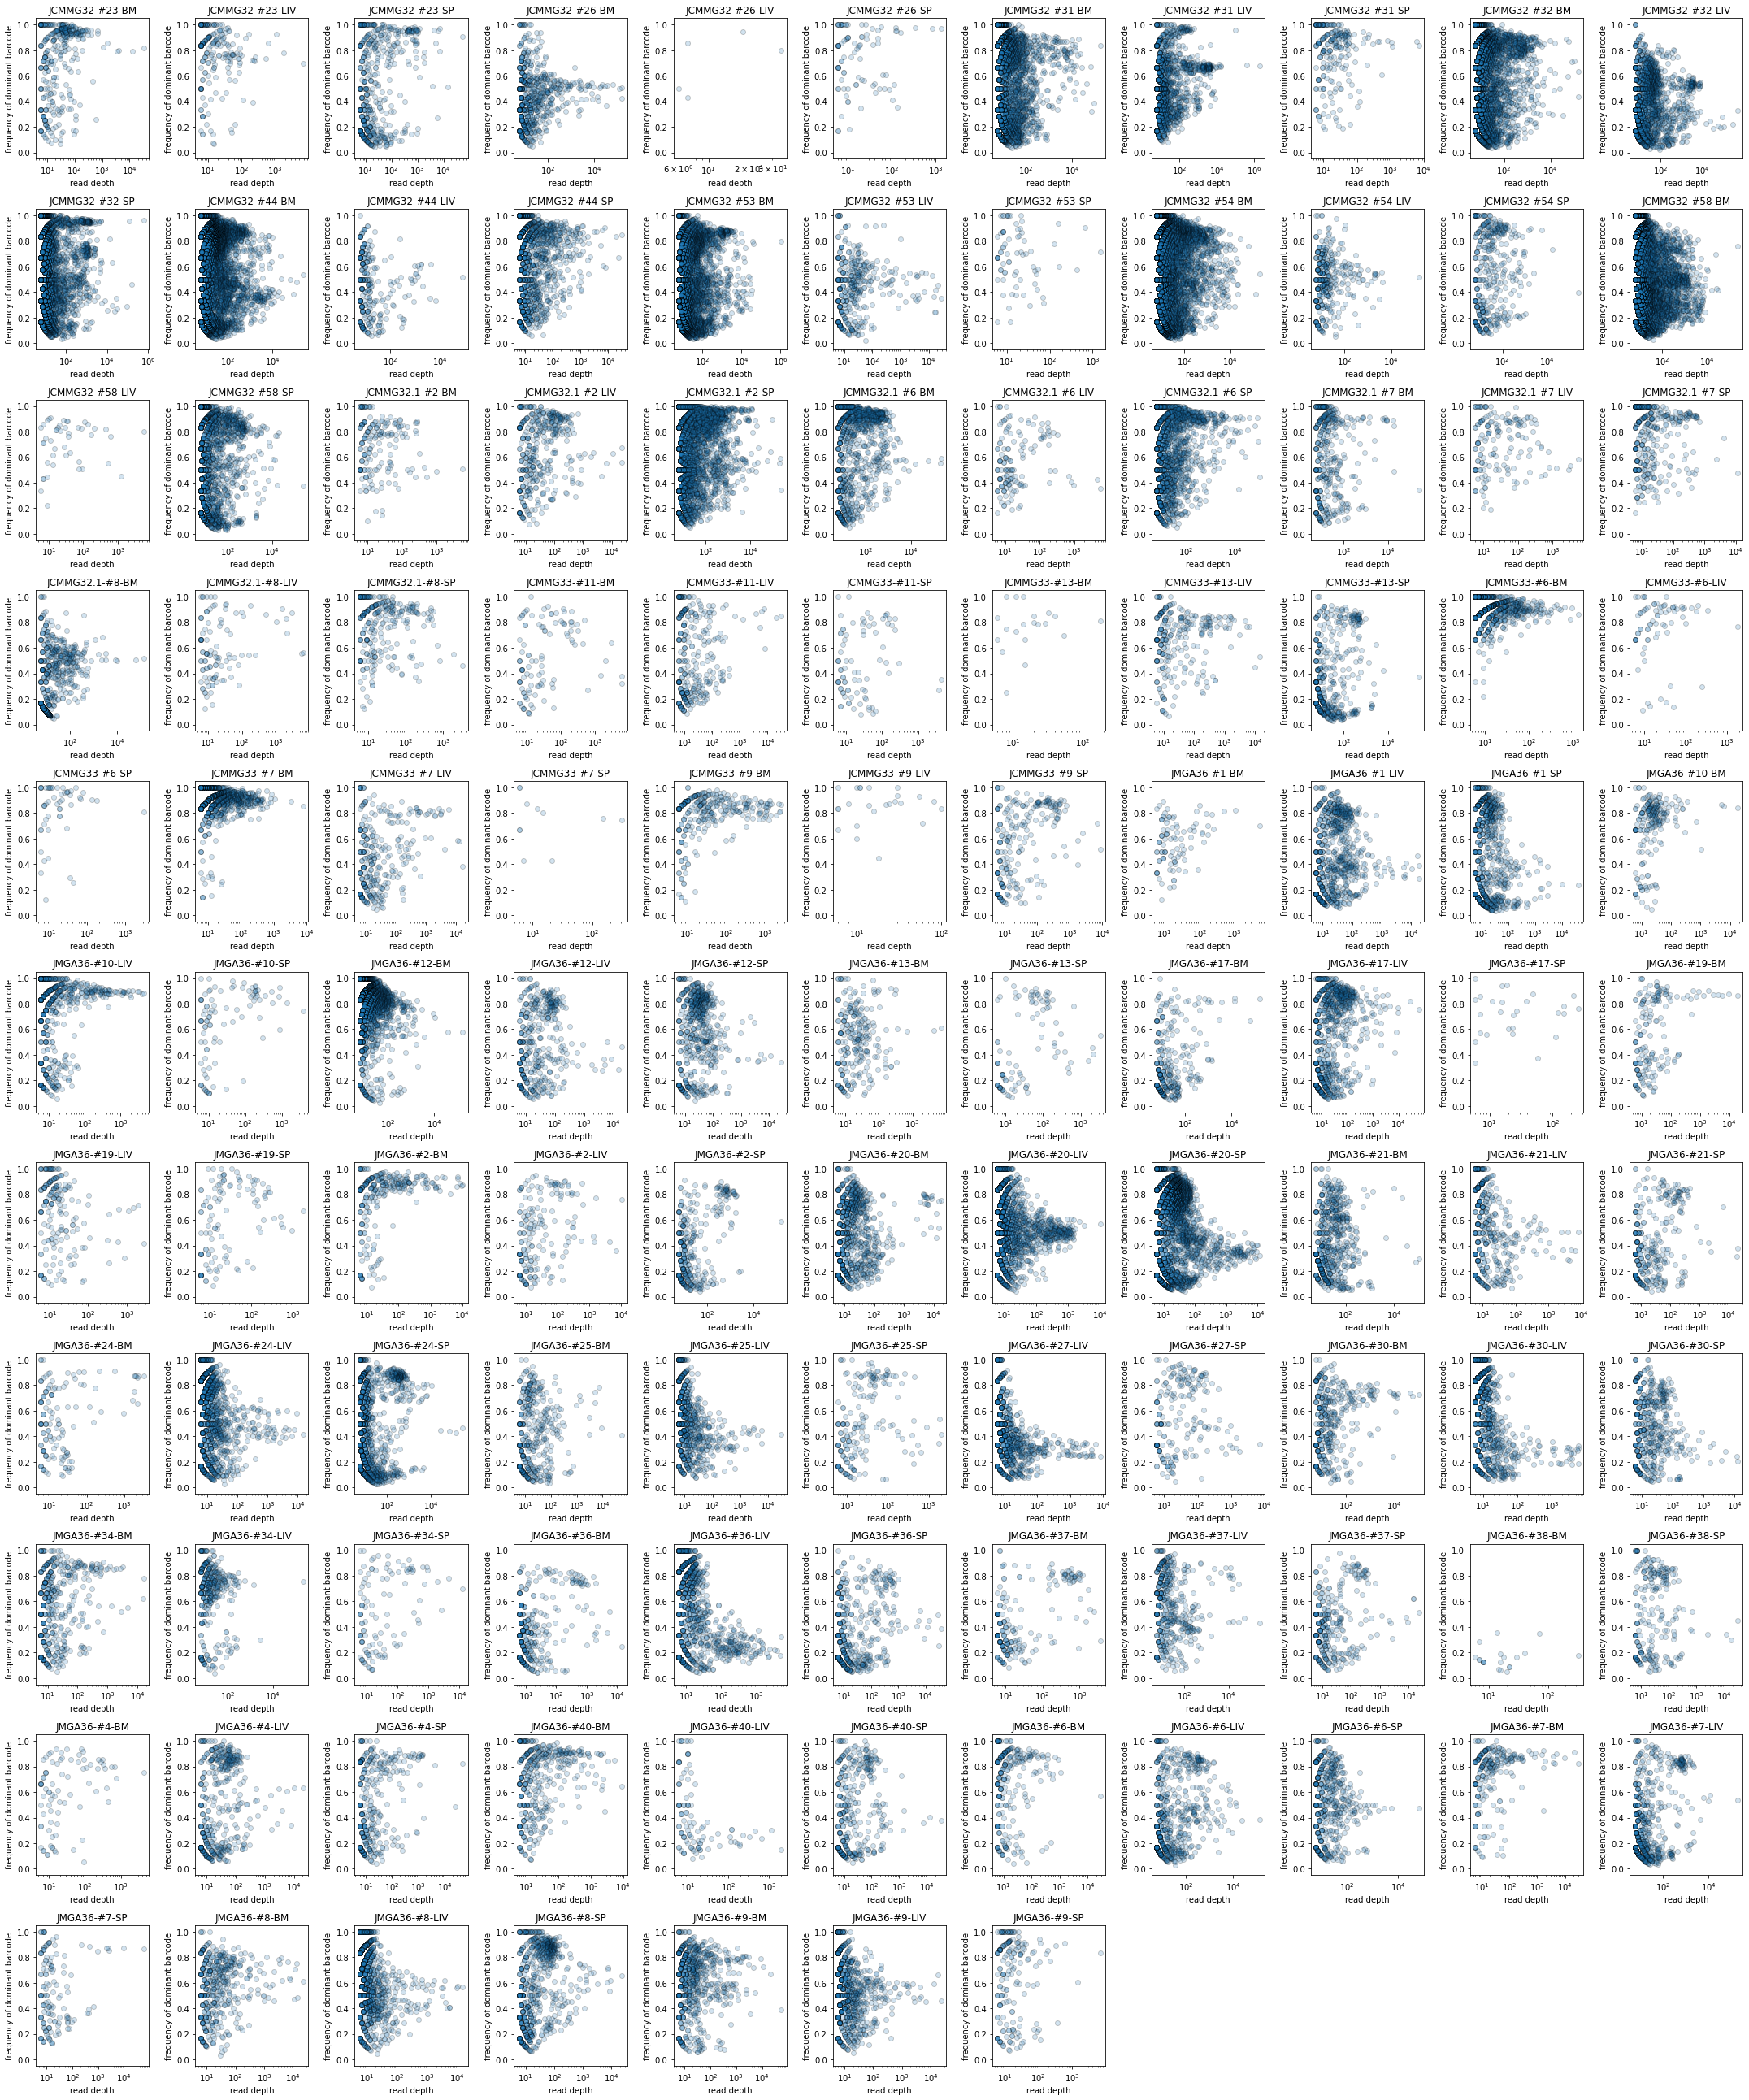

In [34]:
plt.figure(figsize=(30,36))
ploti = 0
for num in SampleIDs:
    ploti += 1
    plt.subplot(11,11,ploti)
    tdata = pdata[num][pdata[num]['read count']>thredict[num]]
    plt.scatter(tdata['read count'],tdata['barcode_confidence'],alpha=0.2,edgecolor='black')
    plt.xscale('log')
    plt.ylim(-0.05,1.05)
    plt.xlabel('read depth')
    plt.ylabel('frequency of dominant barcode')
    plt.title(num)
plt.tight_layout()
plt.savefig('../figures/BCconfidence.png',dpi=300)

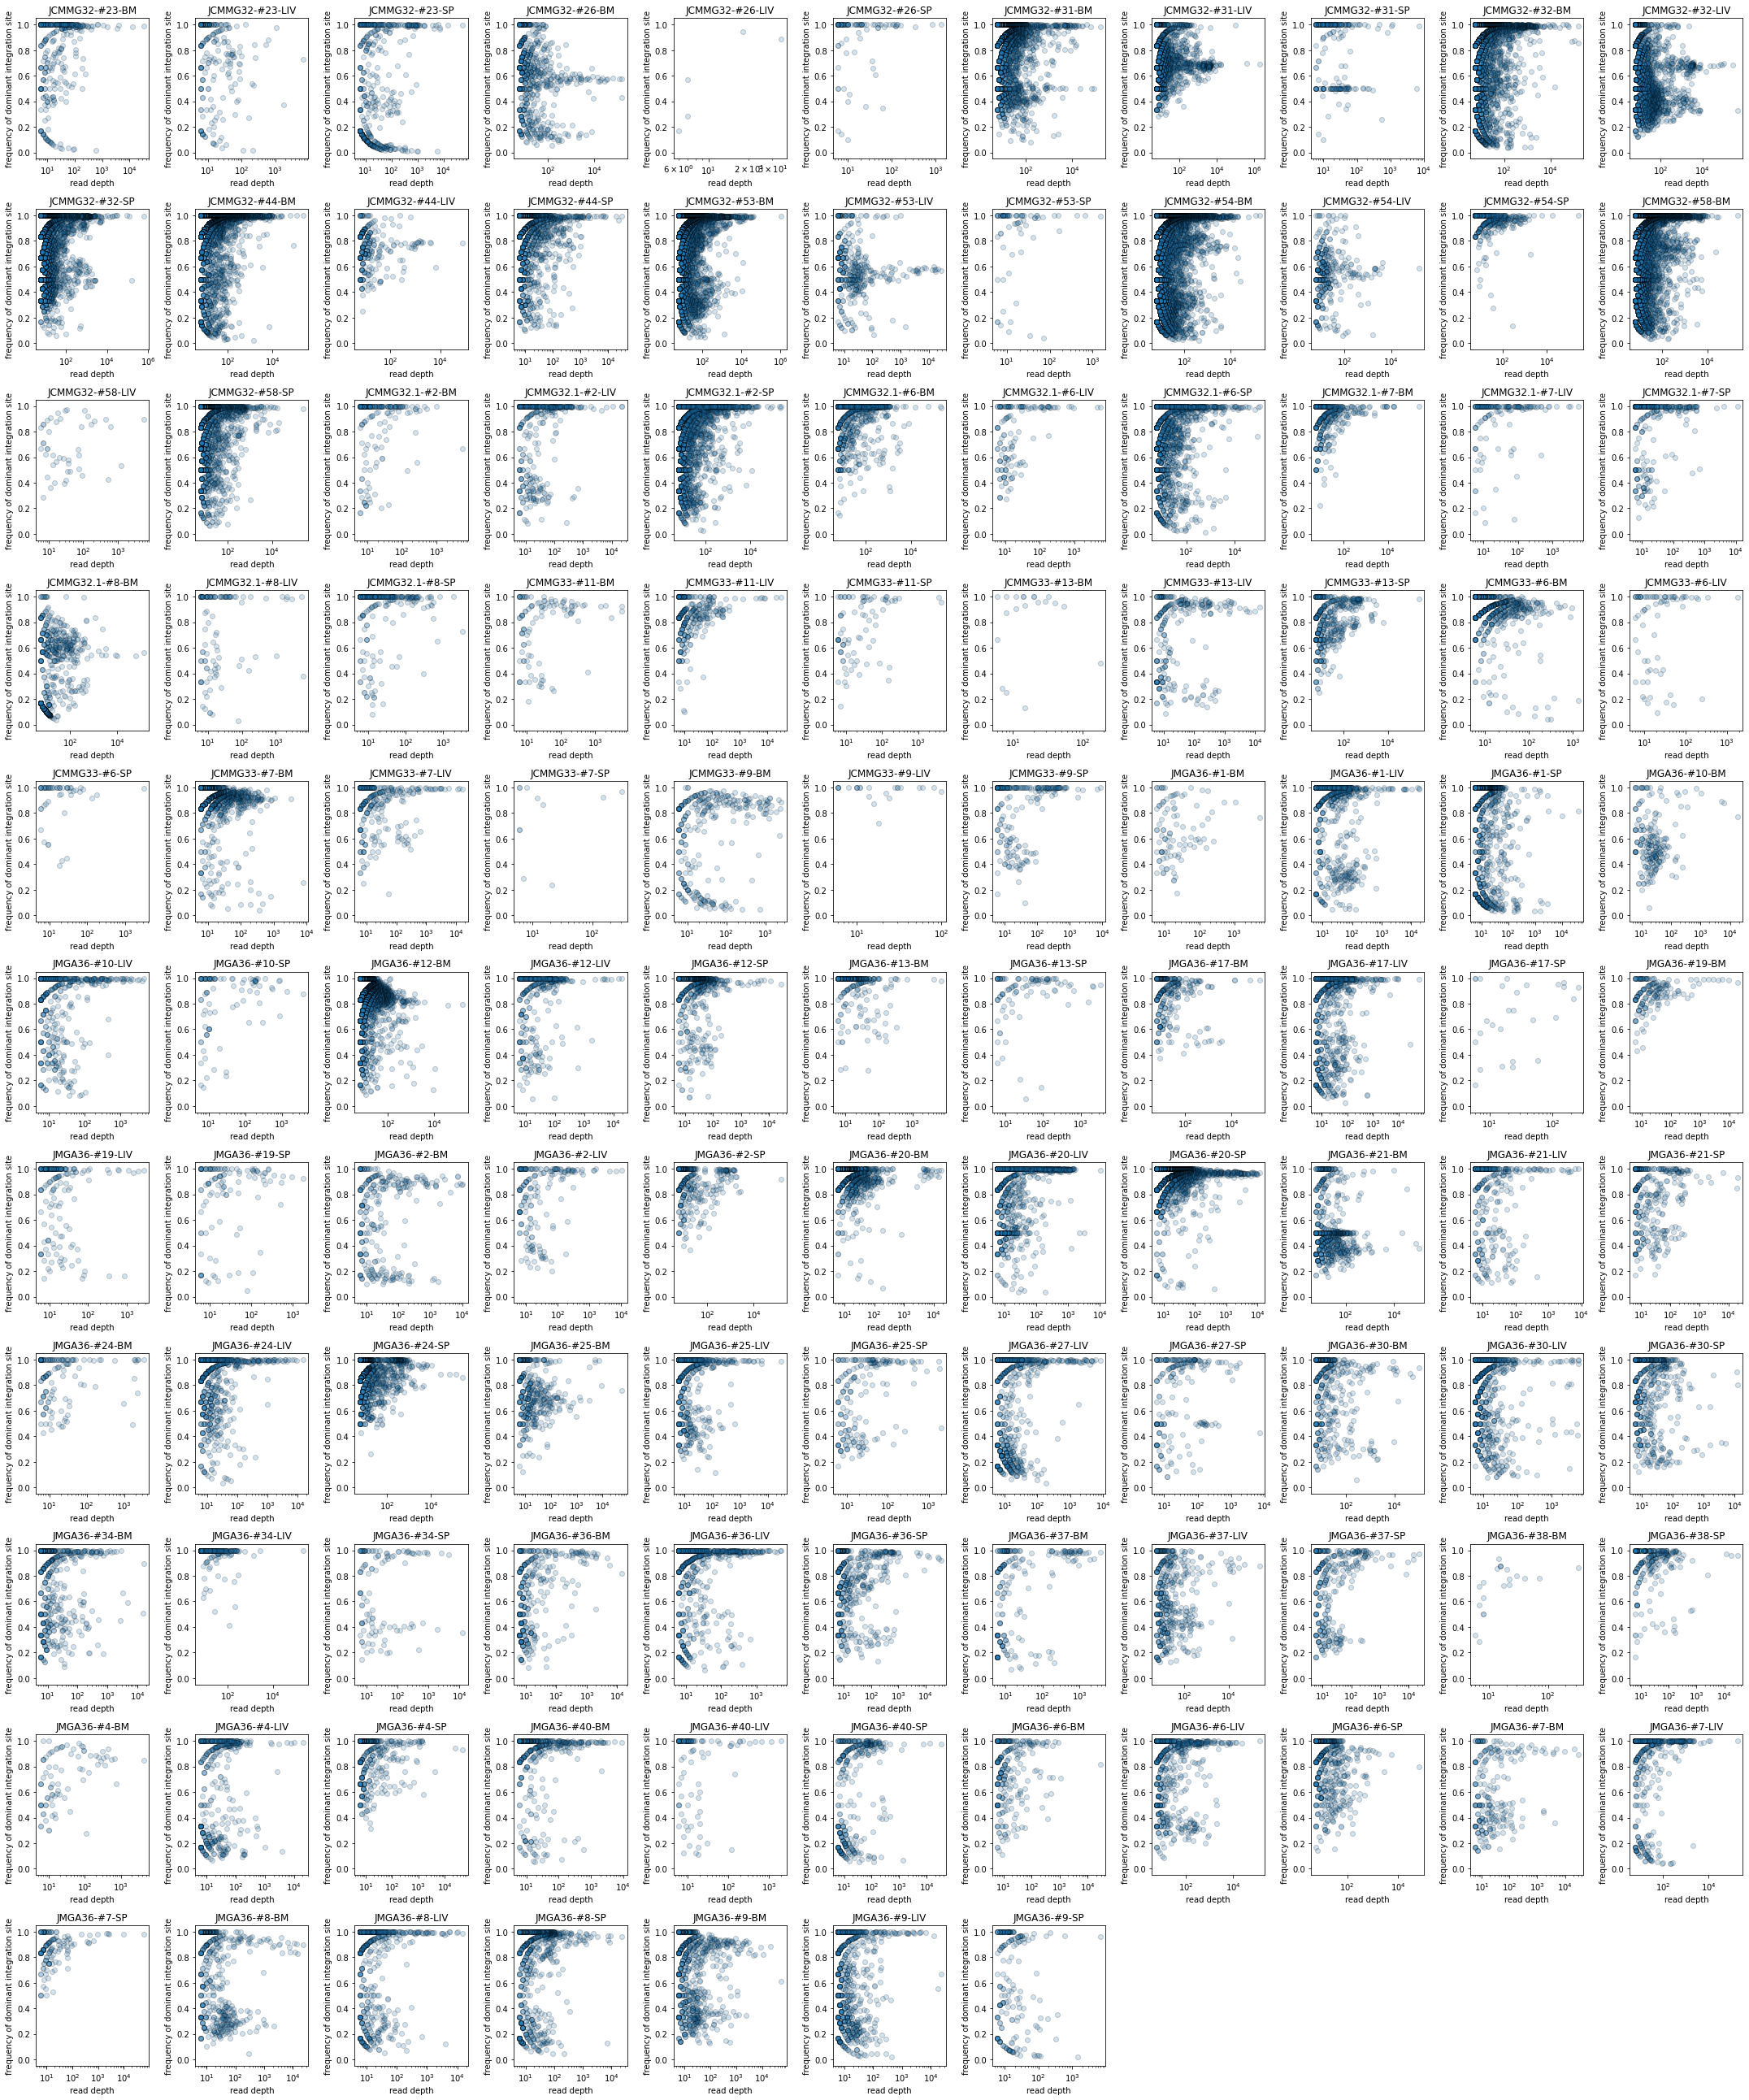

In [35]:
plt.figure(figsize=(30,36))
ploti = 0
for num in SampleIDs:
    ploti += 1
    plt.subplot(11,11,ploti)
    tdata = pdata[num][pdata[num]['read count']>thredict[num]]
    plt.scatter(tdata['read count'],tdata['site_confidence'],alpha=0.2,edgecolor='black')
    plt.xscale('log')
    plt.ylim(-0.05,1.05)
    plt.xlabel('read depth')
    plt.ylabel('frequency of dominant integration site')
    plt.title(num)
plt.tight_layout()
plt.savefig('../figures/ISconfidence.png',dpi=300)

In [36]:
with open('../picklefiles/pdata.pkl','wb') as f:
    pickle.dump(pdata,f)

In [37]:
# from here, data analysis will be used on loading pdata.pkl, instead of the csv file

In [38]:
summary = reffile.drop_duplicates('SampleID')[['SampleID','Mouse_Cohort','MouseID','Organ','Treatment']]

In [39]:
summary['Depth'] = summary['SampleID'].apply(lambda x: np.sum(pdata[x]['read count']))

# provirus types

In [40]:
countdict_all = {}
for sampleID in pdata:
    countdict_all[sampleID] = pdata[sampleID].groupby('provirus type').size()

In [41]:
provirus_types = ['HIV','hg38','plasmid','unintegrated']
frequency_list = []
for sampleID in countdict_all:
    entry = {'sampleID':sampleID}
    total = np.sum(countdict_all[sampleID])
    for ptype in provirus_types:
        entry[ptype] = countdict_all[sampleID][ptype]/total if ptype in countdict_all[sampleID] else 0
    frequency_list.append(entry)

In [42]:
countdict_all[sampleID]

provirus type
HIV                540
hg38              6899
plasmid            237
unintegrated    154671
dtype: int64

In [43]:
ptype_df=pd.DataFrame(frequency_list)

In [44]:
#assign to summary
ptype_dict = ptype_df.set_index('sampleID').to_dict()

In [45]:
for ptype in provirus_types:
    summary['{} fraction'.format(ptype)] = summary['SampleID'].apply(lambda row:ptype_dict[ptype][row])

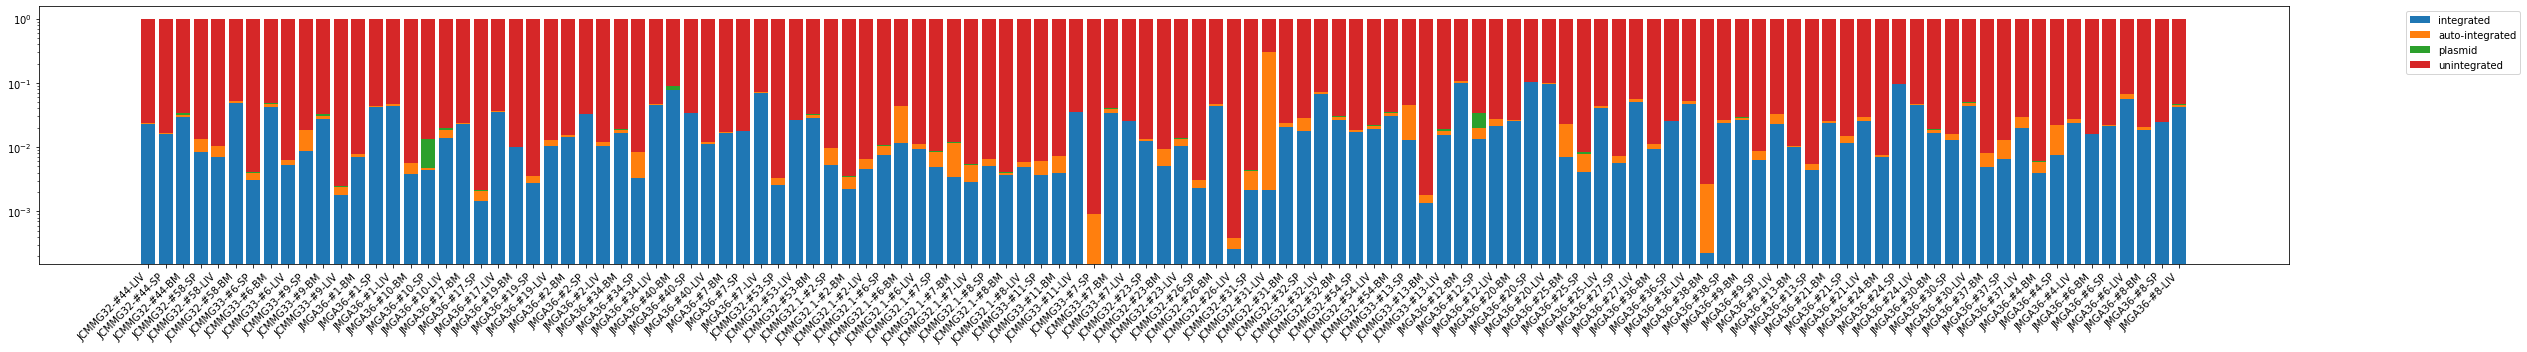

In [46]:
plt.figure(figsize=[35,5])
plt.bar(np.arange(len(ptype_df)),ptype_df['hg38'],label='integrated')
plt.bar(np.arange(len(ptype_df)),ptype_df['HIV'],label='auto-integrated',bottom=ptype_df['hg38'])
plt.bar(np.arange(len(ptype_df)),ptype_df['plasmid'],label='plasmid',bottom=ptype_df['HIV']+ptype_df['hg38'])
plt.bar(np.arange(len(ptype_df)),ptype_df['unintegrated'],label='unintegrated',bottom=ptype_df['HIV']+ptype_df['hg38']+ptype_df['plasmid'])
plt.yscale('log')
plt.xticks(ticks=range(len(ptype_df['sampleID'])), labels=ptype_df['sampleID'],rotation=45,ha='right');
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('../figures/provirus_types.png',dpi=300)

# Filter Data

In [47]:
thredict

{'JCMMG32-#23-BM': 5,
 'JCMMG32-#23-LIV': 5,
 'JCMMG32-#23-SP': 5,
 'JCMMG32-#26-BM': 5,
 'JCMMG32-#26-LIV': 5,
 'JCMMG32-#26-SP': 5,
 'JCMMG32-#31-BM': 5,
 'JCMMG32-#31-LIV': 5,
 'JCMMG32-#31-SP': 5,
 'JCMMG32-#32-BM': 5,
 'JCMMG32-#32-LIV': 5,
 'JCMMG32-#32-SP': 5,
 'JCMMG32-#44-BM': 5,
 'JCMMG32-#44-LIV': 5,
 'JCMMG32-#44-SP': 5,
 'JCMMG32-#53-BM': 5,
 'JCMMG32-#53-LIV': 5,
 'JCMMG32-#53-SP': 5,
 'JCMMG32-#54-BM': 5,
 'JCMMG32-#54-LIV': 5,
 'JCMMG32-#54-SP': 5,
 'JCMMG32-#58-BM': 5,
 'JCMMG32-#58-LIV': 5,
 'JCMMG32-#58-SP': 5,
 'JCMMG32.1-#2-BM': 5,
 'JCMMG32.1-#2-LIV': 5,
 'JCMMG32.1-#2-SP': 5,
 'JCMMG32.1-#6-BM': 5,
 'JCMMG32.1-#6-LIV': 5,
 'JCMMG32.1-#6-SP': 5,
 'JCMMG32.1-#7-BM': 5,
 'JCMMG32.1-#7-LIV': 5,
 'JCMMG32.1-#7-SP': 5,
 'JCMMG32.1-#8-BM': 5,
 'JCMMG32.1-#8-LIV': 5,
 'JCMMG32.1-#8-SP': 5,
 'JCMMG33-#11-BM': 5,
 'JCMMG33-#11-LIV': 5,
 'JCMMG33-#11-SP': 5,
 'JCMMG33-#13-BM': 5,
 'JCMMG33-#13-LIV': 5,
 'JCMMG33-#13-SP': 5,
 'JCMMG33-#6-BM': 5,
 'JCMMG33-#6-LIV': 5,
 'JCMMG

In [48]:
# filter based on thredict
fdata = dict()
for sampleID in SampleIDs:
    tdata = pdata[sampleID]
    fdata[sampleID] = tdata[tdata['read count']>thredict[sampleID]]

In [49]:
fdata[SampleIDs[0]]

UMI  read count                barcode  barcode_confidence  \
0     CTCGAACGGCGTTT          30  GTAGAAGTCGACGGAGCGGCC            0.066667   
1     GATAGGTCAGTTTT        3951  GTAGAAGTCGACGGAGAGGAC            0.798026   
2     AGTCAATCGCTTGC         699  GTAGAAGTCGACGGAGAGGAC            0.951359   
3     CGCGGTTAAGTCAT          54  GTAGAAGTCGACGGAGAGGAC            0.962963   
4     TCGTCCATCCTCTC           8  GTAGAAGTCGACGGAGAGGAC            0.250000   
...              ...         ...                    ...                 ...   
2401  CAATGATTTAGTAG           8  GTAGAAGTCGACGGAGAGGAC            0.750000   
2563  CCGATCACCCTTAG           6  GTAGAAGTCGACGGAGAGGCC            0.333333   
2579  GGTAACCGTAACCG           6  GCAGCCGAGGCCGCTGATGAA            0.833333   
2643  ATGCCTGCTATGCT           8  GTAGAAGTCGACGGAGAGGAC            1.000000   
2767  CGTTCCTATGCGGT           7  GTAGAAGTCGACGGAGAGGAC            0.857143   

     provirus type             site  site_confidence  mapping length  
0             hg38  chrX:21822210:-         0.033333              15  
1             hg38  chr1:39443366:-         0.998481              77  
2             hg38  chr1:39443366:-         0.998569              77  
3             hg38  chr1:39443366:-         1.000000              77  
4              HIV    BCNFNSX:527:+         0.625000              14  
...            ...              ...              ...             ...  
2401           HIV   BCNFNSX:5148:+         0.875000              78  
2563           HIV   BCNFNSX:5186:+         0.500000              40  
2579           HIV    BCNFNSX:527:+         1.000000              79  
2643           HIV   BCNFNSX:8552:+         0.500000              81  
2767           HIV   BCNFNSX:5148:+         0.428571              78  

[377 rows x 8 columns]

In [50]:
# count UMI based on filtered data

In [51]:
countdict = {}
for sampleID in SampleIDs:
    countdict[sampleID] = fdata[sampleID].groupby('provirus type').size()

In [52]:
for ptype in provirus_types:
    summary['{}_UMI_count'.format(ptype)] = summary['SampleID'].apply(lambda x: countdict[x].get(ptype,0))

In [53]:
summary

SampleID Mouse_Cohort MouseID Organ Treatment    Depth  \
0    JCMMG32-#44-LIV      JCMMG32     #44   LIV   D1D2-NK   209192   
1     JCMMG32-#44-SP      JCMMG32     #44    SP   D1D2-NK   777659   
2     JCMMG32-#44-BM      JCMMG32     #44    BM   D1D2-NK  2820269   
6     JCMMG32-#58-SP      JCMMG32     #58    SP   D1D2-NK  1709173   
7    JCMMG32-#58-LIV      JCMMG32     #58   LIV   D1D2-NK    41991   
..               ...          ...     ...   ...       ...      ...   
238     JMGA36-#6-SP       JMGA36      #6    SP     No NK   289363   
241    JMGA36-#6-LIV       JMGA36      #6   LIV     No NK   407225   
242     JMGA36-#8-BM       JMGA36      #8    BM     No NK   286031   
243     JMGA36-#8-SP       JMGA36      #8    SP     No NK   395308   
246    JMGA36-#8-LIV       JMGA36      #8   LIV     No NK   274483   

     HIV fraction  hg38 fraction  plasmid fraction  unintegrated fraction  \
0        0.000364       0.023251          0.000000               0.976384   
1        0.000687       0.015803          0.000280               0.983229   
2        0.002521       0.028942          0.002393               0.966144   
6        0.004678       0.008498          0.000131               0.986692   
7        0.003332       0.006910          0.000070               0.989688   
..            ...            ...               ...                    ...   
238      0.001132       0.021018          0.000000               0.977850   
241      0.011635       0.055448          0.000268               0.932649   
242      0.002029       0.018500          0.000164               0.979306   
243      0.000498       0.024244          0.000008               0.975250   
246      0.003326       0.042495          0.001460               0.952719   

     HIV_UMI_count  hg38_UMI_count  plasmid_UMI_count  unintegrated_UMI_count  
0                2             301                  0                       0  
1               41            1250                  0                       0  
2              434            5835                  0                       0  
6              668            1083                  0                       0  
7                4              42                  0                       0  
..             ...             ...                ...                     ...  
238             34             503                  0                       0  
241            112             574                  0                       0  
242             24             469                  0                       0  
243             21             744                  0                       0  
246             79            1348                  0                       0  

[117 rows x 14 columns]

In [54]:
with open('../picklefiles/fdata.pkl','wb') as f:
    pickle.dump(fdata,f)

with open('../picklefiles/notebook2.pkl','wb') as f:
    pickle.dump({'reffile':reffile,'summary':summary,'SampleIDs':SampleIDs,'provirus_types':provirus_types,'thredict':thredict},f)